In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load datasets
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)


Ratings shape: (100836, 4)
Movies shape: (9742, 3)


In [2]:
user_item_matrix = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

print("User–Item Matrix shape:", user_item_matrix.shape)
print(user_item_matrix.head())


User–Item Matrix shape: (610, 9724)
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN  

In [3]:
# Get unique users and movies
unique_users = ratings['userId'].unique()
unique_movies = ratings['movieId'].unique()

# Create mappings
user_to_index = {user: i for i, user in enumerate(unique_users)}
movie_to_index = {movie: i for i, movie in enumerate(unique_movies)}

# Reverse mappings
index_to_user = {i: user for user, i in user_to_index.items()}
index_to_movie = {i: movie for movie, i in movie_to_index.items()}

# Add index columns
ratings['user_index'] = ratings['userId'].map(user_to_index)
ratings['movie_index'] = ratings['movieId'].map(movie_to_index)

print(ratings.head())
print("Number of users:", len(unique_users))
print("Number of movies:", len(unique_movies))


   userId  movieId  rating  timestamp  user_index  movie_index
0       1        1     4.0  964982703           0            0
1       1        3     4.0  964981247           0            1
2       1        6     4.0  964982224           0            2
3       1       47     5.0  964983815           0            3
4       1       50     5.0  964982931           0            4
Number of users: 610
Number of movies: 9724


In [4]:
# Train-Test Split (80-20)
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_data)} ({len(train_data)/len(ratings)*100:.1f}%)")
print(f"Test set size: {len(test_data)} ({len(test_data)/len(ratings)*100:.1f}%)")
print(f"\nTrain ratings range: {train_data['rating'].min()} - {train_data['rating'].max()}")
print(f"Test ratings range: {test_data['rating'].min()} - {test_data['rating'].max()}")

Training set size: 80668 (80.0%)
Test set size: 20168 (20.0%)

Train ratings range: 0.5 - 5.0
Test ratings range: 0.5 - 5.0


In [5]:
# Number of users and movies
num_users = len(unique_users)
num_movies = len(unique_movies)

# Number of latent factors
k = 20

# Set random seed
np.random.seed(42)

# Initialize matrices
W = np.random.normal(scale=0.1, size=(num_users, k))   # user matrix
X = np.random.normal(scale=0.1, size=(num_movies, k))  # movie matrix

print("User matrix shape:", W.shape)
print("Movie matrix shape:", X.shape)

# Global average rating
global_mean = ratings['rating'].mean()

# Initialize user and movie bias
user_bias = np.zeros(num_users)
movie_bias = np.zeros(num_movies)

print("Global mean rating:", global_mean)


User matrix shape: (610, 20)
Movie matrix shape: (9724, 20)
Global mean rating: 3.501556983616962


In [9]:
# Hyperparameters (Adjusted to reduce overfitting)
alpha = 0.015   # learning rate (reduced)
lambda_reg = 0.25  # regularization (increased significantly)
epochs = 100
k_factors = 25  # latent factors (increased to capture more complexity)

# Re-initialize with fewer latent factors
np.random.seed(42)
W = np.random.normal(scale=0.1, size=(num_users, k_factors))
X = np.random.normal(scale=0.1, size=(num_movies, k_factors))
user_bias = np.zeros(num_users)
movie_bias = np.zeros(num_movies)

print(f"Updated hyperparameters:")
print(f"  Learning rate: {alpha}")
print(f"  Regularization: {lambda_reg}")
print(f"  Latent factors: {k_factors}")
print(f"  Max epochs: {epochs}")
print()

# Store RMSE history
train_rmse_history = []
test_rmse_history = []

# Early stopping parameters
patience = 10
best_test_rmse = float('inf')
patience_counter = 0
best_epoch = 0

# Save best model parameters
best_W = None
best_X = None
best_user_bias = None
best_movie_bias = None

for epoch in range(epochs):
    # Training phase - use only train_data
    train_error = 0
    
    for _, row in train_data.iterrows():
        u = int(row['user_index'])
        m = int(row['movie_index'])
        r = row['rating']
        
        # Prediction with bias
        pred = (
            global_mean
            + user_bias[u]
            + movie_bias[m]
            + np.dot(W[u], X[m])
        )
        
        error = r - pred
        train_error += error**2
        
        # Update biases
        user_bias[u] += alpha * (error - lambda_reg * user_bias[u])
        movie_bias[m] += alpha * (error - lambda_reg * movie_bias[m])
        
        # Update latent factors
        W[u] += alpha * (error * X[m] - lambda_reg * W[u])
        X[m] += alpha * (error * W[u] - lambda_reg * X[m])
    
    # Calculate Train RMSE
    train_rmse = np.sqrt(train_error / len(train_data))
    train_rmse_history.append(train_rmse)
    
    # Evaluation phase - use test_data (no updates)
    test_error = 0
    
    for _, row in test_data.iterrows():
        u = int(row['user_index'])
        m = int(row['movie_index'])
        r = row['rating']
        
        # Prediction with bias
        pred = (
            global_mean
            + user_bias[u]
            + movie_bias[m]
            + np.dot(W[u], X[m])
        )
        
        error = r - pred
        test_error += error**2
    
    # Calculate Test RMSE
    test_rmse = np.sqrt(test_error / len(test_data))
    test_rmse_history.append(test_rmse)
    
    # Early stopping logic
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        best_epoch = epoch + 1
        patience_counter = 0
        # Save best model
        best_W = W.copy()
        best_X = X.copy()
        best_user_bias = user_bias.copy()
        best_movie_bias = movie_bias.copy()
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        status = "✓" if test_rmse == best_test_rmse else ""
        print(f"Epoch {epoch+1:3d}/{epochs} - Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f} {status}")
    
    # Stop if no improvement for 'patience' epochs
    if patience_counter >= patience:
        print(f"\n⚠️ Early stopping at epoch {epoch+1}")
        print(f"No improvement in test RMSE for {patience} consecutive epochs")
        break

# Restore best model
W = best_W
X = best_X
user_bias = best_user_bias
movie_bias = best_movie_bias

print(f"\n{'='*60}")
print(f"✓ Training Complete!")
print(f"{'='*60}")
print(f"Best Test RMSE: {best_test_rmse:.4f} (at epoch {best_epoch})")
print(f"Final Train RMSE: {train_rmse_history[best_epoch-1]:.4f}")
print(f"Overfitting gap: {best_test_rmse - train_rmse_history[best_epoch-1]:.4f}")


Updated hyperparameters:
  Learning rate: 0.015
  Regularization: 0.25
  Latent factors: 25
  Max epochs: 100

Epoch   1/100 - Train RMSE: 0.9350 | Test RMSE: 0.9165 ✓
Epoch   5/100 - Train RMSE: 0.8528 | Test RMSE: 0.8893 ✓
Epoch  10/100 - Train RMSE: 0.8340 | Test RMSE: 0.8835 ✓
Epoch  15/100 - Train RMSE: 0.8244 | Test RMSE: 0.8817 ✓
Epoch  20/100 - Train RMSE: 0.8181 | Test RMSE: 0.8810 ✓
Epoch  25/100 - Train RMSE: 0.8135 | Test RMSE: 0.8808 ✓
Epoch  30/100 - Train RMSE: 0.8098 | Test RMSE: 0.8808 
Epoch  35/100 - Train RMSE: 0.8068 | Test RMSE: 0.8809 

⚠️ Early stopping at epoch 38
No improvement in test RMSE for 10 consecutive epochs

✓ Training Complete!
Best Test RMSE: 0.8808 (at epoch 28)
Final Train RMSE: 0.8112
Overfitting gap: 0.0696


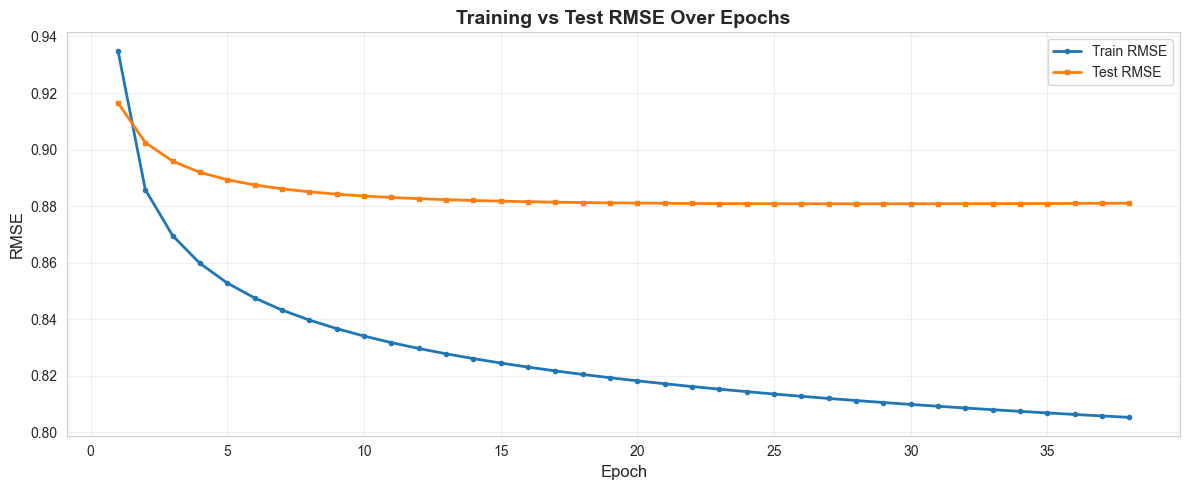


⚠️ Test RMSE is 0.0758 higher than Train RMSE


In [10]:
# Visualize RMSE over epochs
plt.figure(figsize=(12, 5))

plt.plot(range(1, len(train_rmse_history)+1), train_rmse_history, label='Train RMSE', linewidth=2, marker='o', markersize=3)
plt.plot(range(1, len(test_rmse_history)+1), test_rmse_history, label='Test RMSE', linewidth=2, marker='s', markersize=3)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Training vs Test RMSE Over Epochs', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Check for overfitting
if test_rmse_history[-1] > train_rmse_history[-1]:
    gap = test_rmse_history[-1] - train_rmse_history[-1]
    print(f"\n⚠️ Test RMSE is {gap:.4f} higher than Train RMSE")
    if gap > 0.2:
        print("This suggests some overfitting. Consider increasing regularization (lambda_reg).")
else:
    print("\n✓ Model is generalizing well!")


In [11]:
def predict_rating(user_id, movie_id):
    pred = (
        global_mean
        + user_bias[user_id]
        + movie_bias[movie_id]
        + np.dot(W[user_id], X[movie_id])
    )
    
    return np.clip(pred, 0.5, 5.0)


In [12]:
# Test the prediction function on test set samples
print("Sample predictions from test set:")
print("="*70)

sample_test = test_data.head(10)

for idx, row in sample_test.iterrows():
    u = int(row['user_index'])
    m = int(row['movie_index'])
    actual = row['rating']
    predicted = predict_rating(u, m)
    movie_title = movies[movies['movieId'] == row['movieId']]['title'].values[0]
    
    print(f"Movie: {movie_title[:40]:<40}")
    print(f"  Actual: {actual:.2f} | Predicted: {predicted:.2f} | Error: {abs(actual-predicted):.2f}")
    print()

Sample predictions from test set:
Movie: Robin Hood (2010)                       
  Actual: 4.50 | Predicted: 3.04 | Error: 1.46

Movie: In the Line of Fire (1993)              
  Actual: 3.00 | Predicted: 3.33 | Error: 0.33

Movie: Point Break (1991)                      
  Actual: 3.00 | Predicted: 2.79 | Error: 0.21

Movie: Who Framed Roger Rabbit? (1988)         
  Actual: 4.00 | Predicted: 3.78 | Error: 0.22

Movie: Hunt for Red October, The (1990)        
  Actual: 4.00 | Predicted: 3.44 | Error: 0.56

Movie: Lord of Illusions (1995)                
  Actual: 4.00 | Predicted: 3.05 | Error: 0.95

Movie: 300 (2007)                              
  Actual: 3.50 | Predicted: 3.83 | Error: 0.33

Movie: Dr. Strangelove or: How I Learned to Sto
  Actual: 4.50 | Predicted: 3.53 | Error: 0.97

Movie: Charlie's Angels: Full Throttle (2003)  
  Actual: 0.50 | Predicted: 2.90 | Error: 2.40

Movie: Anchorman: The Legend of Ron Burgundy (2
  Actual: 3.50 | Predicted: 3.86 | Error: 0.36



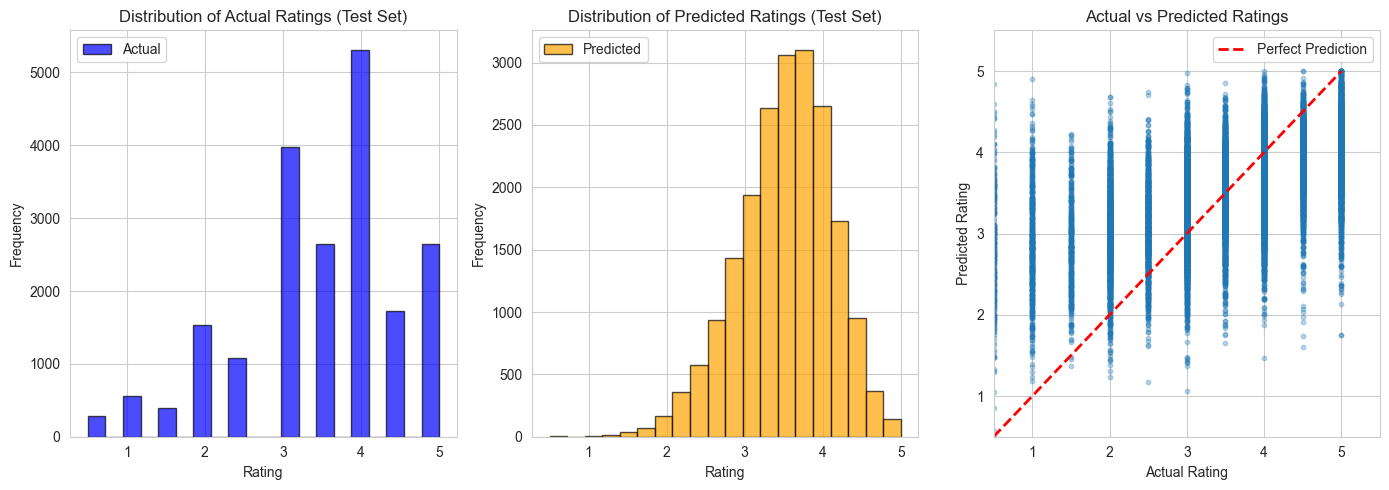

Predicted ratings range: 0.50 - 5.00
Mean predicted rating: 3.52
Mean actual rating: 3.50


In [ ]:
# Analyze prediction distribution
test_predictions = []
test_actuals = []

for _, row in test_data.iterrows():
    u = int(row['user_index'])
    m = int(row['movie_index'])
    test_predictions.append(predict_rating(u, m))
    test_actuals.append(row['rating'])

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(test_actuals, bins=20, alpha=0.7, label='Actual', color='blue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Ratings (Test Set)')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(test_predictions, bins=20, alpha=0.7, label='Predicted', color='orange', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Ratings (Test Set)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(test_actuals, test_predictions, alpha=0.3, s=10)
plt.plot([0.5, 5], [0.5, 5], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')
plt.legend()
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)

plt.tight_layout()
plt.show()

print(f"Predicted ratings range: {min(test_predictions):.2f} - {max(test_predictions):.2f}")
print(f"Mean predicted rating: {np.mean(test_predictions):.2f}")
print(f"Mean actual rating: {np.mean(test_actuals):.2f}")

In [13]:
def recommend_movies(user_id, user_item_matrix, predicted_ratings, movies, top_n=5):
    # Predicted ratings for the user
    user_predictions = predicted_ratings[user_id]
    
    # Movies already rated
    user_rated = user_item_matrix.iloc[user_id]
    watched_movies = user_rated[user_rated.notna()].index
    
    # Create prediction dataframe
    predictions_df = pd.DataFrame({
        'movieId': user_item_matrix.columns,
        'predicted_rating': user_predictions
    })
    
    # Remove watched movies
    predictions_df = predictions_df[~predictions_df['movieId'].isin(watched_movies)]
    
    # Get top N recommendations
    top_recommendations = predictions_df.sort_values(
        by='predicted_rating',
        ascending=False
    ).head(top_n)
    
    # Merge with movie titles
    top_recommendations = top_recommendations.merge(
        movies,
        on='movieId'
    )
    
    return top_recommendations[['title', 'predicted_rating']]


In [14]:
# Create full predicted ratings matrix
predicted_ratings = np.zeros((num_users, num_movies))

for u in range(num_users):
    for m in range(num_movies):
        predicted_ratings[u, m] = (
            global_mean
            + user_bias[u]
            + movie_bias[m]
            + np.dot(W[u], X[m])
        )

# Clip values to valid rating range
predicted_ratings = np.clip(predicted_ratings, 0.5, 5.0)


In [ ]:
user_id = 0 # first user

top_movies = recommend_movies(
    user_id,
    user_item_matrix,
    predicted_ratings,
    movies,
    top_n=5
)

print("Top 5 recommended movies:")
print(top_movies)


Top 5 recommended movies:
                            title  predicted_rating
0  xXx: State of the Union (2005)          4.954671
1            Smoke Signals (1998)          4.932090
2                   Ishtar (1987)          4.896049
3                     Taxi (1998)          4.892030
4                   Easy A (2010)          4.859710
